In [3]:
# Import necessary libraries
%matplotlib inline
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi

# Install required packages
!pip install pydicom

# Disable warnings
warnings.filterwarnings("ignore")

# Set dataset path - adjust as needed for your environment
DATASET_PATH = '/kaggle/input/luna16/'

In [4]:
# Function to safely explore dataset structure with correct handling of nested folders
def explore_dataset(base_path):
    """Explore the LUNA16 dataset structure with proper error handling for nested folders"""
    try:
        print("Exploring LUNA dataset structure...")
        for item in sorted(os.listdir(base_path)):
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                print(f"📁 {item}/")
                # Check if this is a subset folder with nested structure
                if item.startswith('subset'):
                    # Check for nested folder with same name
                    nested_path = os.path.join(item_path, item)
                    if os.path.exists(nested_path) and os.path.isdir(nested_path):
                        print(f"  └── 📁 {item}/ (nested)")
                        subfiles = os.listdir(nested_path)[:5]  # Show first 5 files
                        for subfile in subfiles:
                            print(f"      └── {subfile}")
                    else:
                        # Regular structure
                        subfiles = os.listdir(item_path)[:5]
                        for subfile in subfiles:
                            print(f"  └── {subfile}")
                else:
                    # Regular folder
                    subfiles = os.listdir(item_path)[:5]
                    for subfile in subfiles:
                        print(f"  └── {subfile}")
            else:
                print(f"📄 {item}")
        print("\n")
    except FileNotFoundError:
        print(f"Error: Path {base_path} not found. Please check your dataset path.")
    except PermissionError:
        print(f"Error: Permission denied for {base_path}.")
    except Exception as e:
        print(f"Error exploring folders: {str(e)}")

# Helper function to find the correct path to subset files
def get_subset_path(base_path, subset_name):
    """
    Get the correct path to a subset folder, handling nested structure
    
    Parameters:
    - base_path: Base dataset path
    - subset_name: Name of the subset (e.g. 'subset0')
    
    Returns:
    - Full path to the subset folder with .mhd files
    """
    # First check if there's a nested structure
    direct_path = os.path.join(base_path, subset_name)
    nested_path = os.path.join(direct_path, subset_name)
    
    # Check if nested path exists and contains .mhd files
    if os.path.exists(nested_path) and os.path.isdir(nested_path):
        if any(f.endswith('.mhd') for f in os.listdir(nested_path)):
            return nested_path
    
    # Otherwise return the direct path
    return direct_path

# Function to load metadata CSV files with error handling
def load_metadata(base_path):
    """Load annotations and candidates CSV files"""
    annotations_path = os.path.join(base_path, 'annotations.csv')
    candidates_path = os.path.join(base_path, 'candidates.csv')
    
    try:
        annotations = pd.read_csv(annotations_path)
        print(f"✓ Loaded annotations: {annotations.shape[0]} entries")
    except FileNotFoundError:
        print(f"Error: Annotations file not found at {annotations_path}")
        annotations = None
    
    try:
        candidates = pd.read_csv(candidates_path)
        print(f"✓ Loaded candidates: {candidates.shape[0]} entries")
    except FileNotFoundError:
        print(f"Error: Candidates file not found at {candidates_path}")
        candidates = None
        
    return annotations, candidates

# Enhanced function to load CT scans
def load_scan(mhd_path):
    """
    Load a CT scan from a .mhd file with proper error handling
    Returns scan array in Hounsfield Units, origin, spacing and metadata
    """
    try:
        # Read the .mhd file using SimpleITK
        itk_img = sitk.ReadImage(mhd_path)
        
        # Convert the image to a numpy array
        scan_array = sitk.GetArrayFromImage(itk_img)  # Shape: [z, y, x]
        
        # Get image metadata
        origin = np.array(itk_img.GetOrigin())       # Coordinates of the origin
        spacing = np.array(itk_img.GetSpacing())     # Spacing between pixels (z, y, x)
        direction = np.array(itk_img.GetDirection())  # Direction cosines
        
        # Get the RescaleIntercept (for proper HU conversion)
        intercept = itk_img.GetMetaData("0028|1052") if itk_img.HasMetaDataKey("0028|1052") else "-1024"
        intercept = float(intercept)
        
        # Convert to Hounsfield Units
        scan_hu = get_pixels_hu(scan_array, intercept)
        
        return scan_hu, origin, spacing, direction
    
    except Exception as e:
        print(f"Error loading scan {mhd_path}: {str(e)}")
        return None, None, None, None

def get_pixels_hu(scan_array, intercept):
    """Convert the scan array to Hounsfield Units (HU)"""
    # Convert to int16
    image = scan_array.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield Units (HU)
    image = image + float(intercept)
    
    return image.astype(np.int16)

# Function to segment lung tissue
def segment_lung_mask(ct_scan, fill_lung_structures=True):
    """
    Segment the lungs from the CT scan
    
    Parameters:
    - ct_scan: CT scan in Hounsfield Units
    - fill_lung_structures: Boolean to determine whether to fill structures inside lungs
    
    Returns:
    - Binary mask of the lungs
    """
    # Threshold the HU to get binary image (-320 is a good threshold for lungs)
    binary_image = ct_scan < -320
    
    # Remove noise
    binary_image = ndi.binary_erosion(binary_image, structure=np.ones((2, 2, 2)))
    binary_image = ndi.binary_dilation(binary_image, structure=np.ones((2, 2, 2)))
    
    # Label the image
    labels, num_labels = ndi.label(binary_image)
    
    # Get background label (assuming background is the largest region)
    label_sizes = np.bincount(labels.flatten())
    if len(label_sizes) > 1:
        background_label = np.argmax(label_sizes[1:]) + 1
    else:
        return np.zeros_like(ct_scan, dtype=bool)
    
    # Create lung mask (everything that's not background or outside edges)
    lung_mask = ~(labels == background_label)
    
    # Alternative approach: Keep the two largest regions (left and right lungs)
    if fill_lung_structures:
        for i in range(ct_scan.shape[0]):
            slice_mask = lung_mask[i]
            if np.sum(slice_mask) > 0:  # If there's anything in the mask
                # Get regions
                labels, num_labels = ndi.label(slice_mask)
                regions = [(labels == i).sum() for i in range(1, num_labels + 1)]
                
                # Only keep the two largest regions if more than one region exists
                if len(regions) > 2:
                    max_regions = np.argsort(regions)[-2:] + 1  # +1 because labels start from 1
                    new_mask = np.zeros_like(slice_mask)
                    for region in max_regions:
                        new_mask = new_mask | (labels == region)
                    lung_mask[i] = new_mask
    
    return lung_mask

# Function to display CT scan slices and associated lung masks
def display_scan_with_mask(scan, mask, num_slices=3, figsize=(15, 10)):
    """
    Display CT scan slices with corresponding lung masks side by side
    
    Parameters:
    - scan: The CT scan in Hounsfield Units
    - mask: The binary lung mask
    - num_slices: Number of slices to display
    - figsize: Figure size
    """
    fig, axes = plt.subplots(num_slices, 2, figsize=figsize)
    
    # Calculate slice indices to spread evenly across the scan
    z_indices = np.linspace(0, scan.shape[0]-1, num_slices).astype(int)
    
    for i, z in enumerate(z_indices):
        # Display original scan
        axes[i, 0].imshow(scan[z], cmap=plt.cm.gray)
        axes[i, 0].set_title(f'Original CT Scan (Slice {z})')
        axes[i, 0].axis('off')
        
        # Display masked scan
        axes[i, 1].imshow(scan[z] * mask[z], cmap=plt.cm.gray)
        axes[i, 1].set_title(f'Lung Mask Applied (Slice {z})')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Convert world coordinates to pixel coordinates
def world_to_pixel(world_coord, origin, spacing):
    """Convert world coordinates to pixel/voxel coordinates"""
    return np.round((world_coord - origin) / spacing).astype(int)

# Function to visualize a nodule
def display_nodule(scan, nodule_center, diameter_mm, spacing, window=50):
    """
    Display a slice with the nodule highlighted
    
    Parameters:
    - scan: CT scan in Hounsfield Units
    - nodule_center: Coordinates of nodule center [x, y, z] in world space
    - diameter_mm: Diameter of the nodule in mm
    - spacing: Voxel spacing
    - window: Window size around nodule in pixels
    """
    # Convert world coordinates to pixel coordinates
    center_pixel = world_to_pixel(nodule_center, np.array([0, 0, 0]), spacing)
    # Reorder from [x,y,z] to [z,y,x] for numpy array indexing
    center_pixel = center_pixel[::-1]
    
    # Calculate radius in pixels
    radius_pixels = int(diameter_mm / (2 * min(spacing)))
    
    # Get the z-slice containing the nodule
    z_slice = center_pixel[0]
    
    if z_slice < 0 or z_slice >= scan.shape[0]:
        print(f"Warning: Nodule z-coordinate {z_slice} is outside scan range {scan.shape[0]}")
        return
    
    # Create a window around the nodule
    y_min = max(0, center_pixel[1] - window)
    y_max = min(scan.shape[1], center_pixel[1] + window)
    x_min = max(0, center_pixel[2] - window)
    x_max = min(scan.shape[2], center_pixel[2] + window)
    
    # Create the figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Show the scan slice
    ax.imshow(scan[z_slice], cmap=plt.cm.gray)
    
    # Draw circle around nodule
    circle = plt.Circle((center_pixel[2], center_pixel[1]), radius_pixels, 
                        color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # Set limits to zoom on the nodule
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_max, y_min)  # Reverse y-axis for correct orientation
    
    ax.set_title(f'Nodule at z={z_slice}, diameter={diameter_mm:.1f}mm')
    ax.axis('off')
    plt.show()

# Function to create HU histograms with lung segmentation
def plot_hu_histograms(scan, lung_mask=None):
    """
    Plot histograms of Hounsfield Units with separate distributions for lung tissue
    
    Parameters:
    - scan: CT scan in Hounsfield Units
    - lung_mask: Binary mask of lungs (if available)
    """
    plt.figure(figsize=(12, 6))
    
    # Full histogram
    plt.hist(scan.flatten(), bins=80, alpha=0.5, color='blue', label='Full Scan')
    
    # Lung-only histogram if mask is available
    if lung_mask is not None:
        lung_pixels = scan[lung_mask]
        plt.hist(lung_pixels.flatten(), bins=80, alpha=0.5, color='red', label='Lung Tissue')
    
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Hounsfield Units")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Function to create enhanced visualizations of a slice
def visualize_slice_enhanced(scan, slice_idx, lung_mask=None):
    """
    Create enhanced visualization of a CT slice with multiple views
    
    Parameters:
    - scan: CT scan in Hounsfield Units
    - slice_idx: Index of the slice to visualize
    - lung_mask: Binary lung mask (if available)
    """
    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Get the slice
    slice_data = scan[slice_idx]
    
    # 1. Regular CT view
    axes[0, 0].imshow(slice_data, cmap=plt.cm.gray)
    axes[0, 0].set_title('Original CT Slice')
    axes[0, 0].axis('off')
    
    # 2. Lung window view (-600 to 1500 HU)
    lung_window = np.clip(slice_data.copy(), -600, 1500)
    axes[0, 1].imshow(lung_window, cmap=plt.cm.gray)
    axes[0, 1].set_title('Lung Window (-600 to 1500 HU)')
    axes[0, 1].axis('off')
    
    # 3. Bone window (400 to 1500 HU)
    bone_window = np.clip(slice_data.copy(), 400, 1500)
    axes[1, 0].imshow(bone_window, cmap=plt.cm.gray)
    axes[1, 0].set_title('Bone Window (400 to 1500 HU)')
    axes[1, 0].axis('off')
    
    # 4. Soft tissue window (50 to 350 HU)
    soft_window = np.clip(slice_data.copy(), 50, 350)
    axes[1, 1].imshow(soft_window, cmap=plt.cm.gray)
    axes[1, 1].set_title('Soft Tissue Window (50 to 350 HU)')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # If lung mask is available, show it
    if lung_mask is not None:
        mask_slice = lung_mask[slice_idx]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original slice
        axes[0].imshow(slice_data, cmap=plt.cm.gray)
        axes[0].set_title('Original CT Slice')
        axes[0].axis('off')
        
        # Masked slice (lung only)
        masked_slice = slice_data.copy()
        masked_slice[~mask_slice] = 0  # Zero out non-lung regions
        axes[1].imshow(masked_slice, cmap=plt.cm.gray)
        axes[1].set_title('Segmented Lung Tissue')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

def analyze_nodules(annotations):
    """
    Analyze nodule statistics from annotations
    
    Parameters:
    - annotations: DataFrame containing nodule annotations
    """
    if annotations is None or len(annotations) == 0:
        print("No annotations available for analysis")
        return
    
    # Print column names to verify the structure
    print("Available columns:", annotations.columns.tolist())
    
    # Check if 'diameter' column exists, otherwise look for alternatives
    if 'diameter' in annotations.columns:
        diameter_col = 'diameter'
    elif 'diameter_mm' in annotations.columns:
        diameter_col = 'diameter_mm'
    # Check for other possible column names that might contain diameter info
    elif any('diam' in col.lower() for col in annotations.columns):
        diameter_col = next(col for col in annotations.columns if 'diam' in col.lower())
    else:
        print("Error: Cannot find diameter information in annotations")
        return
    
    # Create a new diameter_mm column if needed
    if diameter_col != 'diameter_mm':
        # If the diameter is already in mm, don't multiply by 2
        if 'mm' in diameter_col.lower():
            annotations['diameter_mm'] = annotations[diameter_col]
        else:
            # Otherwise assume it's a radius and multiply by 2 to get diameter
            annotations['diameter_mm'] = annotations[diameter_col] * 2
    
    # Group by seriesuid to get nodules per patient
    nodules_per_patient = annotations.groupby('seriesuid').size()
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Distribution of nodule diameters
    sns.histplot(annotations['diameter_mm'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Nodule Diameters')
    axes[0, 0].set_xlabel('Diameter (mm)')
    axes[0, 0].set_ylabel('Count')
    
    # 2. Nodules per patient
    sns.histplot(nodules_per_patient, kde=False, ax=axes[0, 1])
    axes[0, 1].set_title('Nodules per Patient')
    axes[0, 1].set_xlabel('Number of Nodules')
    axes[0, 1].set_ylabel('Number of Patients')
    
    # Check if coordinate columns exist
    if all(col in annotations.columns for col in ['coordX', 'coordY', 'coordZ']):
        # 3. Scatter plot of nodule locations (x vs y)
        axes[1, 0].scatter(annotations['coordX'], annotations['coordY'], 
                         alpha=0.6, s=annotations['diameter_mm']*3)
        axes[1, 0].set_title('Nodule Locations (X vs Y)')
        axes[1, 0].set_xlabel('X Coordinate (mm)')
        axes[1, 0].set_ylabel('Y Coordinate (mm)')
        
        # 4. Scatter plot of nodule locations (z vs diameter)
        axes[1, 1].scatter(annotations['coordZ'], annotations['diameter_mm'], 
                         alpha=0.6)
        axes[1, 1].set_title('Nodule Z-Position vs Diameter')
        axes[1, 1].set_xlabel('Z Coordinate (mm)')
        axes[1, 1].set_ylabel('Diameter (mm)')
    else:
        # If coordinate columns don't exist, print message
        for ax in [axes[1, 0], axes[1, 1]]:
            ax.text(0.5, 0.5, "Coordinate data not available", 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nNodule Statistics:")
    print(f"Total number of nodules: {len(annotations)}")
    print(f"Number of patients with nodules: {len(nodules_per_patient)}")
    print(f"Avg nodules per patient: {nodules_per_patient.mean():.2f}")
    print(f"Min diameter: {annotations['diameter_mm'].min():.2f} mm")
    print(f"Max diameter: {annotations['diameter_mm'].max():.2f} mm")
    print(f"Mean diameter: {annotations['diameter_mm'].mean():.2f} mm")
    print(f"Median diameter: {annotations['diameter_mm'].median():.2f} mm")

# Function to create 3D visualization of lungs
def plot_3d(image, threshold=-320):
    """
    Plot 3D surface of lung volume
    
    Parameters:
    - image: 3D numpy array of CT scan
    - threshold: HU threshold for lung tissue
    """
    try:
        # Position the scan upright
        p = image.transpose(2, 1, 0)
        
        # Create binary mask with threshold
        verts, faces, _, _ = measure.marching_cubes(p, threshold)
        
        # Create mesh
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces], alpha=0.7)
        mesh.set_edgecolor('k')
        mesh.set_facecolor('green')
        ax.add_collection3d(mesh)
        
        # Set limits
        ax.set_xlim(0, p.shape[0])
        ax.set_ylim(0, p.shape[1])
        ax.set_zlim(0, p.shape[2])
        
        # Set labels and title
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title("3D Lung Visualization")
        
        plt.show()
    except Exception as e:
        print(f"Error in 3D visualization: {str(e)}")

# Function to find all scans (handling nested folders)
def find_all_scans(base_path):
    """
    Find all .mhd scans in the dataset, handling nested folder structure
    
    Parameters:
    - base_path: Base dataset path
    
    Returns:
    - List of dictionaries with subset_name and full_path to each scan
    """
    all_scans = []
    
    # Find all subset folders
    subset_folders = [f for f in os.listdir(base_path) 
                     if f.startswith('subset') and os.path.isdir(os.path.join(base_path, f))]
    
    for subset in subset_folders:
        # Get the correct path (handling nested folders)
        subset_path = get_subset_path(base_path, subset)
        
        # Find all .mhd files in this subset
        mhd_files = [f for f in os.listdir(subset_path) if f.endswith('.mhd')]
        
        for mhd_file in mhd_files:
            scan_path = os.path.join(subset_path, mhd_file)
            all_scans.append({
                'subset': subset,
                'filename': mhd_file,
                'path': scan_path,
                'patient_id': os.path.splitext(mhd_file)[0]
            })
    
    return all_scans


In [5]:
def main():
    print("Starting LUNA16 Dataset Analysis")
    print("================================\n")
    
    # Step 1: Explore dataset structure
    explore_dataset(DATASET_PATH)
    
    # Step 2: Load metadata
    annotations, candidates = load_metadata(DATASET_PATH)
    
    if annotations is not None:
        print("\nAnnotations Sample:")
        display(annotations.head())
        # Print column names to help debugging
        print("Annotation columns:", annotations.columns.tolist())
        
    if candidates is not None:
        print("\nCandidates Sample:")
        display(candidates.head())
    
    # Step 3: Find all scans
    all_scans = find_all_scans(DATASET_PATH)
    print(f"\nFound {len(all_scans)} scans in the dataset")
    
    if not all_scans:
        print("Error: No scans found in the dataset!")
        return
    
    # Find a scan with nodules first, instead of just loading the first scan
    selected_scan = None
    scan_hu = None
    origin = None
    spacing = None
    direction = None
    
    if annotations is not None:
        print("\nSearching for a scan with nodules...")
        for scan_info in all_scans:
            scan_id = scan_info['patient_id']
            # Check if this scan has nodules in annotations
            scan_annotations = annotations[annotations['seriesuid'] == scan_id]
            
            if len(scan_annotations) > 0:
                print(f"Found scan with nodules: {scan_id}")
                selected_scan = scan_info
                print(f"Loading scan from: {selected_scan['path']}")
                
                scan_hu, origin, spacing, direction = load_scan(selected_scan['path'])
                
                if scan_hu is not None:
                    print(f"Successfully loaded scan with nodules: {scan_id}")
                    break
    
    # If we didn't find a scan with nodules or couldn't load it, fall back to the first scan
    if scan_hu is None:
        print("\nNo scan with nodules found or failed to load. Using the first available scan.")
        selected_scan = all_scans[0]
        print(f"Loading scan: {selected_scan['path']}")
        scan_hu, origin, spacing, direction = load_scan(selected_scan['path'])
    
    # If still no scan loaded, try one more alternative
    if scan_hu is None:
        print("Failed to load scan. Trying another scan...")
        # Try the second scan if available
        if len(all_scans) > 1:
            selected_scan = all_scans[1]
            print(f"\nLoading alternate scan: {selected_scan['path']}")
            scan_hu, origin, spacing, direction = load_scan(selected_scan['path'])
            if scan_hu is None:
                print("Failed to load alternate scan. Exiting.")
                return
        else:
            print("No alternative scans available. Exiting.")
            return
    
    print(f"Scan loaded successfully: {scan_hu.shape}")
    print(f"Spacing: {spacing}")
    print(f"Origin: {origin}")
    
    # Remaining visualization code...
    slice_idx = scan_hu.shape[0] // 2  # Middle slice
    
    plt.figure(figsize=(10, 8))
    plt.imshow(scan_hu[slice_idx], cmap='gray')
    plt.title(f"CT Scan Slice {slice_idx}")
    plt.axis('off')
    plt.show()
    
    # HU distribution
    plot_hu_histograms(scan_hu)
    
    # Enhanced slice visualization
    visualize_slice_enhanced(scan_hu, slice_idx)
    
    # Segment lungs
    print("\nSegmenting lungs...")
    lung_mask = segment_lung_mask(scan_hu)
    print(f"Lung segmentation complete: {np.sum(lung_mask)} voxels segmented as lung tissue")
    
    # Display scan with lung mask
    display_scan_with_mask(scan_hu, lung_mask)
    
    # Plot histograms with lung segmentation
    plot_hu_histograms(scan_hu, lung_mask)
    
    # Display enhanced visualizations with lung mask
    visualize_slice_enhanced(scan_hu, slice_idx, lung_mask)
    
    # Analyze nodule statistics if annotations are available
    if annotations is not None:
        print("\nAnalyzing nodule statistics...")
        
        # Fixed analyze_nodules function to handle missing 'diameter' column
        def analyze_nodules_fixed(annotations_df):
            """Fixed function to analyze nodule statistics"""
            if annotations_df is None or len(annotations_df) == 0:
                print("No annotations available for analysis")
                return
            
            # Print column names for debugging
            print("Available columns:", annotations_df.columns.tolist())
            
            # Check if diameter-related columns exist
            diameter_available = False
            
            # Try different possible column names for diameter
            if 'diameter' in annotations_df.columns:
                annotations_df['diameter_mm'] = annotations_df['diameter'] * 2
                diameter_available = True
            elif 'diameter_mm' in annotations_df.columns:
                # Already in mm, no need to convert
                diameter_available = True
            elif 'nodule_size' in annotations_df.columns:
                annotations_df['diameter_mm'] = annotations_df['nodule_size']
                diameter_available = True
            
            # If no diameter column found, create a placeholder
            if not diameter_available:
                print("Warning: No diameter column found. Using default values.")
                annotations_df['diameter_mm'] = 10.0  # Default 10mm
            
            # Group by seriesuid to get nodules per patient
            nodules_per_patient = annotations_df.groupby('seriesuid').size()
            
            # Create plots
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # 1. Distribution of nodule diameters
            sns.histplot(annotations_df['diameter_mm'], kde=True, ax=axes[0, 0])
            axes[0, 0].set_title('Distribution of Nodule Diameters')
            axes[0, 0].set_xlabel('Diameter (mm)')
            axes[0, 0].set_ylabel('Count')
            
            # 2. Nodules per patient
            sns.histplot(nodules_per_patient, kde=False, ax=axes[0, 1])
            axes[0, 1].set_title('Nodules per Patient')
            axes[0, 1].set_xlabel('Number of Nodules')
            axes[0, 1].set_ylabel('Number of Patients')
            
            # Check if coordinate columns exist
            coord_cols = ['coordX', 'coordY', 'coordZ']
            if all(col in annotations_df.columns for col in coord_cols):
                # 3. Scatter plot of nodule locations (x vs y)
                axes[1, 0].scatter(annotations_df['coordX'], annotations_df['coordY'], 
                                alpha=0.6, s=annotations_df['diameter_mm']*3)
                axes[1, 0].set_title('Nodule Locations (X vs Y)')
                axes[1, 0].set_xlabel('X Coordinate (mm)')
                axes[1, 0].set_ylabel('Y Coordinate (mm)')
                
                # 4. Scatter plot of nodule locations (z vs diameter)
                axes[1, 1].scatter(annotations_df['coordZ'], annotations_df['diameter_mm'], 
                                alpha=0.6)
                axes[1, 1].set_title('Nodule Z-Position vs Diameter')
                axes[1, 1].set_xlabel('Z Coordinate (mm)')
                axes[1, 1].set_ylabel('Diameter (mm)')
            else:
                print(f"Warning: Missing coordinate columns. Available columns: {annotations_df.columns.tolist()}")
                # Display message in the plot
                for ax in [axes[1, 0], axes[1, 1]]:
                    ax.text(0.5, 0.5, "Coordinate data not available", 
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax.transAxes)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print("\nNodule Statistics:")
            print(f"Total number of nodules: {len(annotations_df)}")
            print(f"Number of patients with nodules: {len(nodules_per_patient)}")
            print(f"Avg nodules per patient: {nodules_per_patient.mean():.2f}")
            print(f"Min diameter: {annotations_df['diameter_mm'].min():.2f} mm")
            print(f"Max diameter: {annotations_df['diameter_mm'].max():.2f} mm")
            print(f"Mean diameter: {annotations_df['diameter_mm'].mean():.2f} mm")
            print(f"Median diameter: {annotations_df['diameter_mm'].median():.2f} mm")
        
        # Call the fixed function
        analyze_nodules_fixed(annotations)
        
        # Display nodules for the current scan if any exist
        scan_id = selected_scan['patient_id']
        scan_annotations = annotations[annotations['seriesuid'] == scan_id]
        
        if len(scan_annotations) > 0:
            print(f"\nFound {len(scan_annotations)} nodules in the current scan")
            
            # Display the first nodule
            first_nodule = scan_annotations.iloc[0]
            
            # Safely get coordinates
            if all(col in scan_annotations.columns for col in ['coordX', 'coordY', 'coordZ']):
                nodule_center = [
                    first_nodule['coordX'], 
                    first_nodule['coordY'], 
                    first_nodule['coordZ']
                ]
                
                # Safely get diameter
                if 'diameter' in scan_annotations.columns:
                    nodule_diameter = first_nodule['diameter'] * 2
                elif 'diameter_mm' in scan_annotations.columns:
                    nodule_diameter = first_nodule['diameter_mm']
                else:
                    print("Warning: No diameter information. Using default value.")
                    nodule_diameter = 10.0  # Default value
                
                # Display the nodule
                display_nodule(scan_hu, nodule_center, nodule_diameter, spacing)
            else:
                print("Cannot display nodule: missing coordinate information")
        else:
            print("\nNo nodules found in the current scan")
    
    # Create 3D visualization
    # Downsample for faster 3D rendering
    downsample_factor = 4
    downsampled_scan = scan_hu[::downsample_factor, ::downsample_factor, ::downsample_factor]
    
    try:
        print("\nCreating 3D visualization... (this may take a moment)")
        plot_3d(downsampled_scan)
    except Exception as e:
        print(f"3D visualization failed: {str(e)}")
    
    print("\nAnalysis complete!")

Starting LUNA16 Dataset Analysis

Exploring LUNA dataset structure...
📄 annotations.csv
📄 candidates.csv
📁 candidates_V2/
  └── candidates_V2.csv
📁 evaluationScript/
  └── evaluationScript
📄 sampleSubmission.csv
📁 seg-lungs-LUNA16/
  └── seg-lungs-LUNA16
📁 subset0/
  └── 📁 subset0/ (nested)
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.raw
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.raw
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.raw
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
📁 subset1/
  └── 📁 subset1/ (nested)
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556.raw
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
      └── 1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
      └── 1.3.6.1.4.1.14519.5.2.1.6279.

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


Annotation columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']

Candidates Sample:


,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0



Found 445 scans in the dataset

Searching for a scan with nodules...
Found scan with nodules: 1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305
Loading scan from: /kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
Successfully loaded scan with nodules: 1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305
Scan loaded successfully: (133, 512, 512)
Spacing: [0.703125 0.703125 2.5     ]
Origin: [-179. -180. -357.]


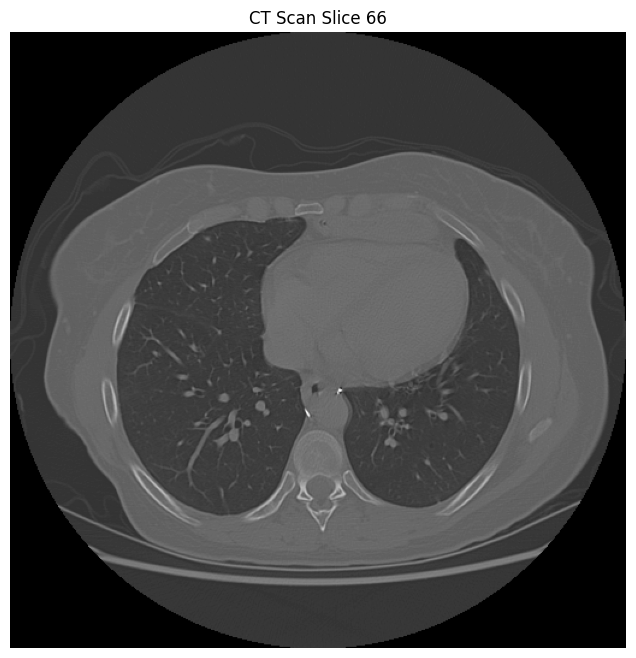

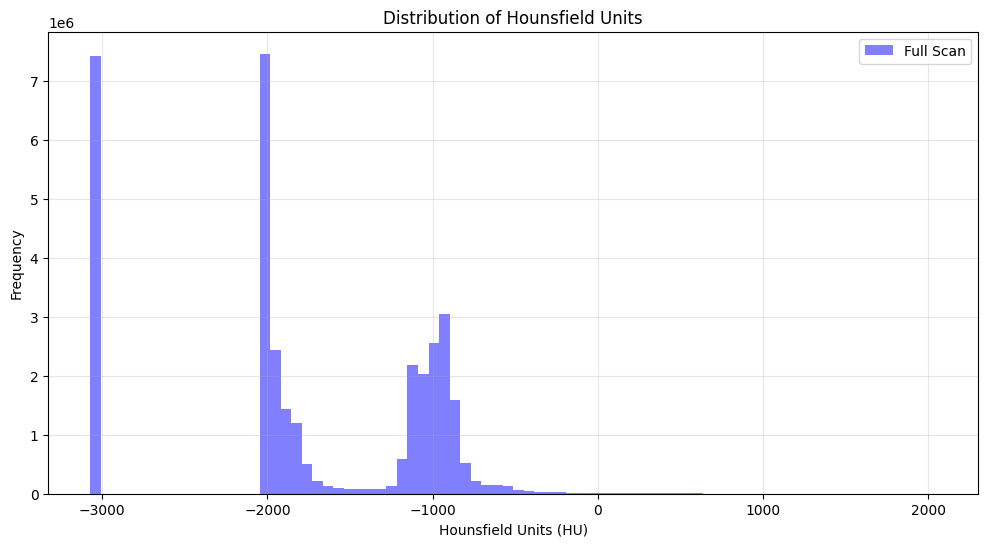

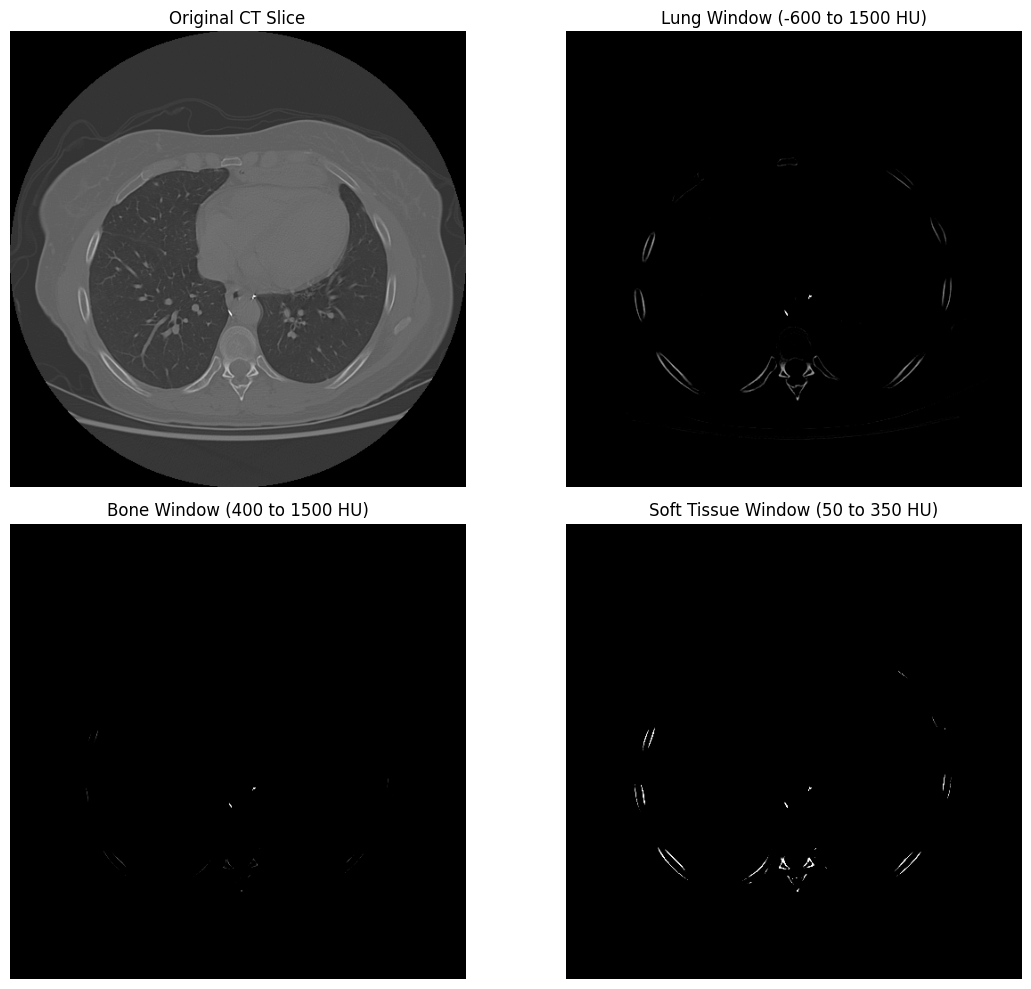


Segmenting lungs...
Lung segmentation complete: 75126 voxels segmented as lung tissue


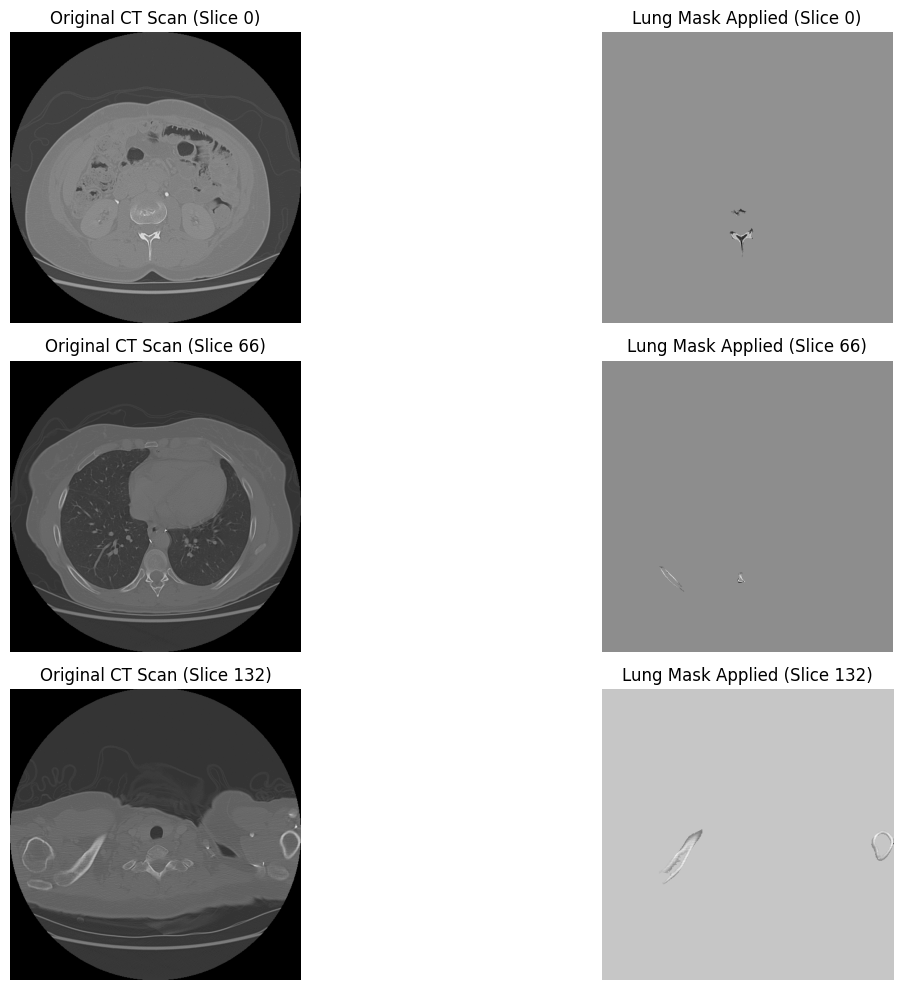

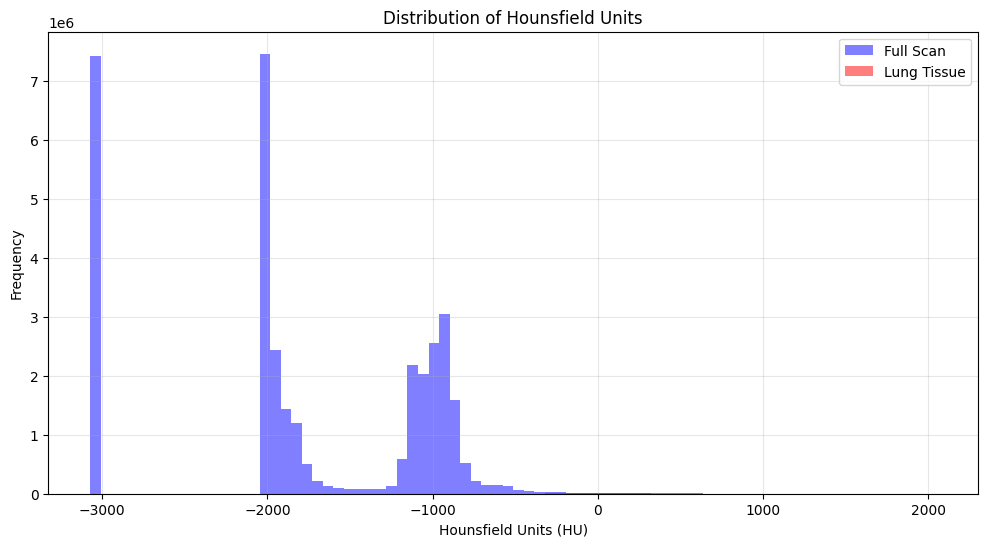

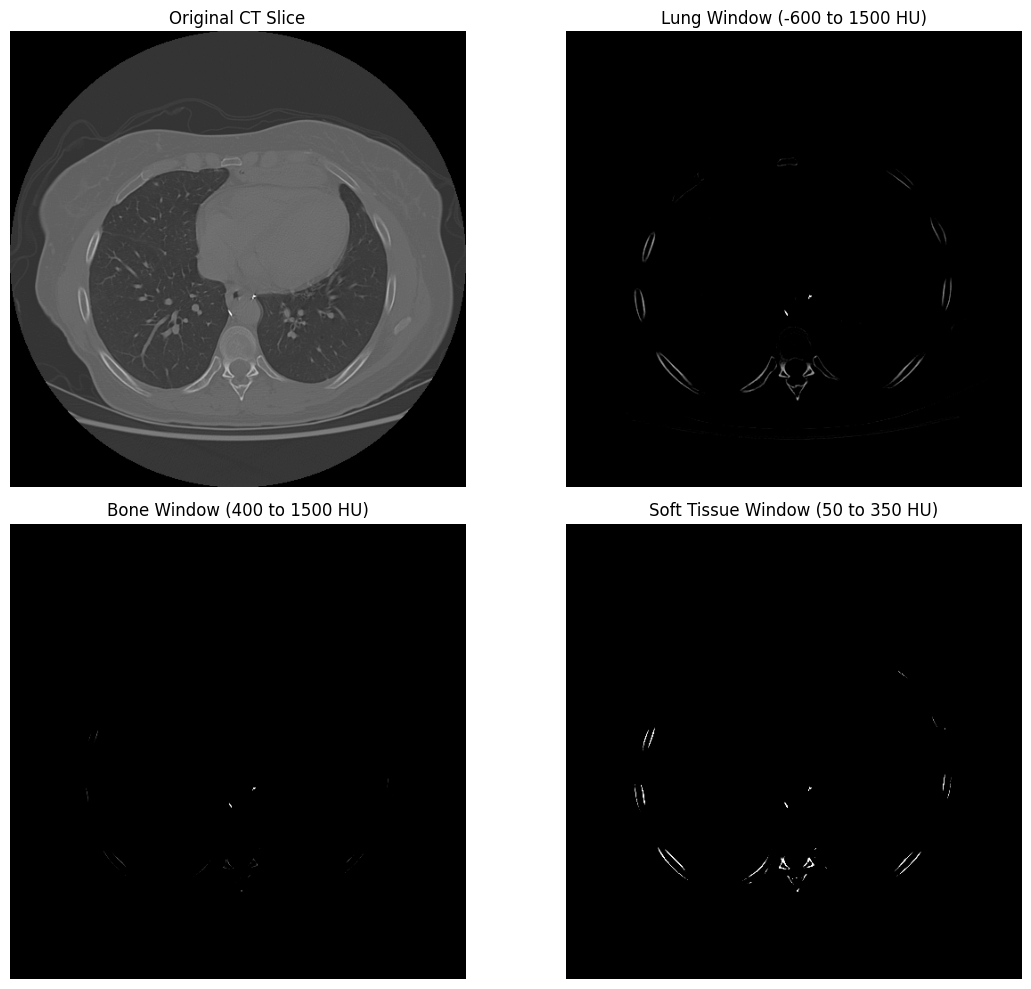

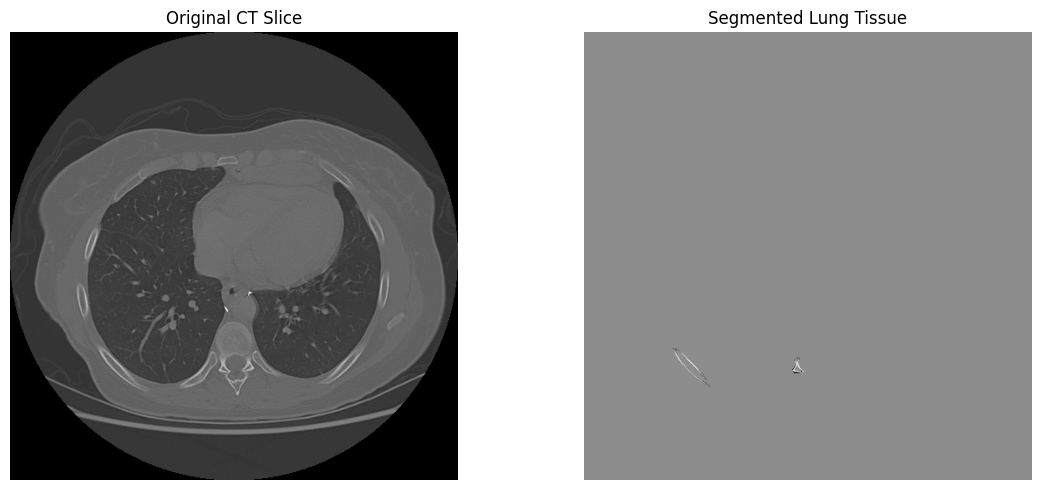


Analyzing nodule statistics...
Available columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']


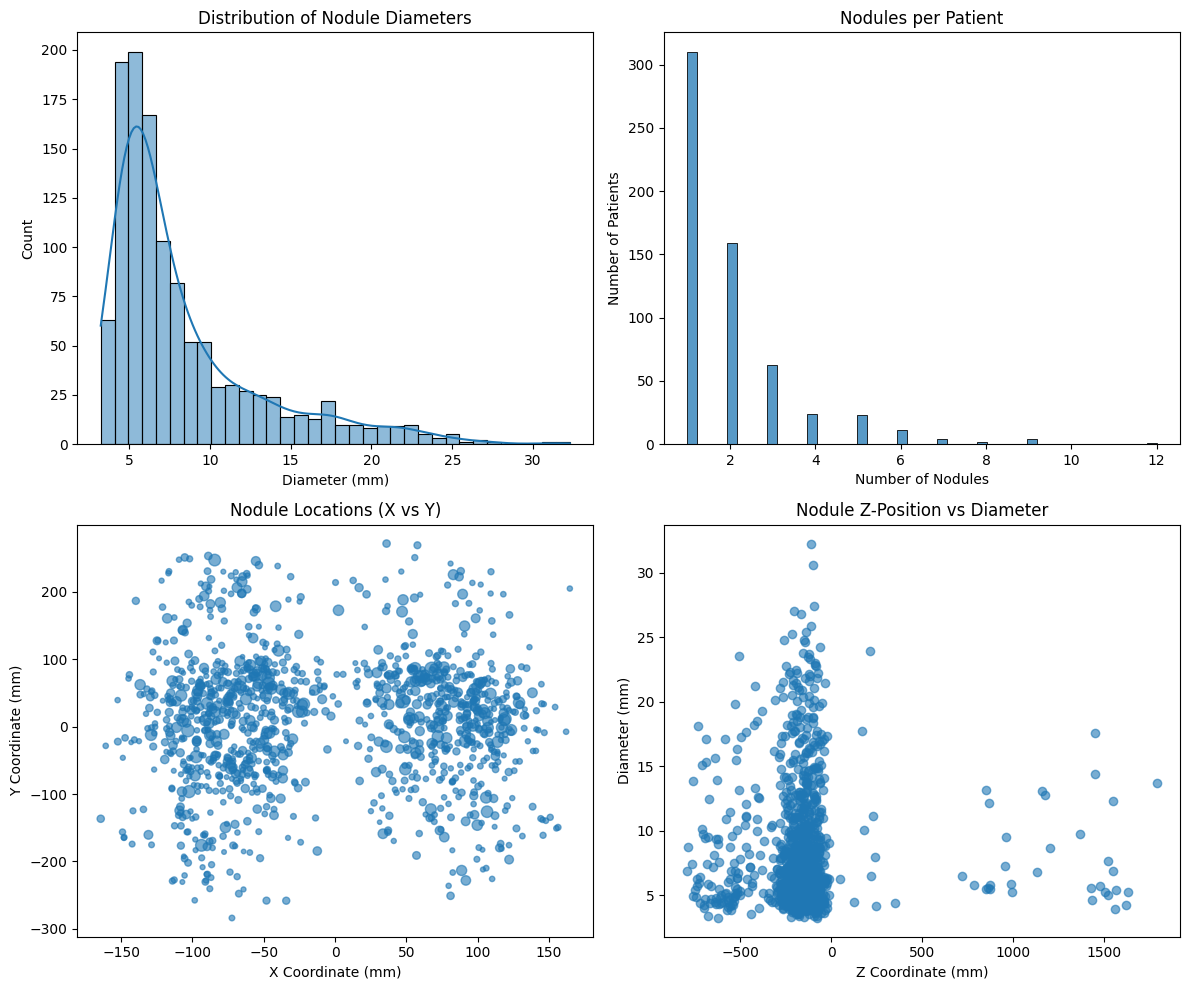


Nodule Statistics:
Total number of nodules: 1186
Number of patients with nodules: 601
Avg nodules per patient: 1.97
Min diameter: 3.25 mm
Max diameter: 32.27 mm
Mean diameter: 8.31 mm
Median diameter: 6.43 mm

Found 1 nodules in the current scan

Creating 3D visualization... (this may take a moment)


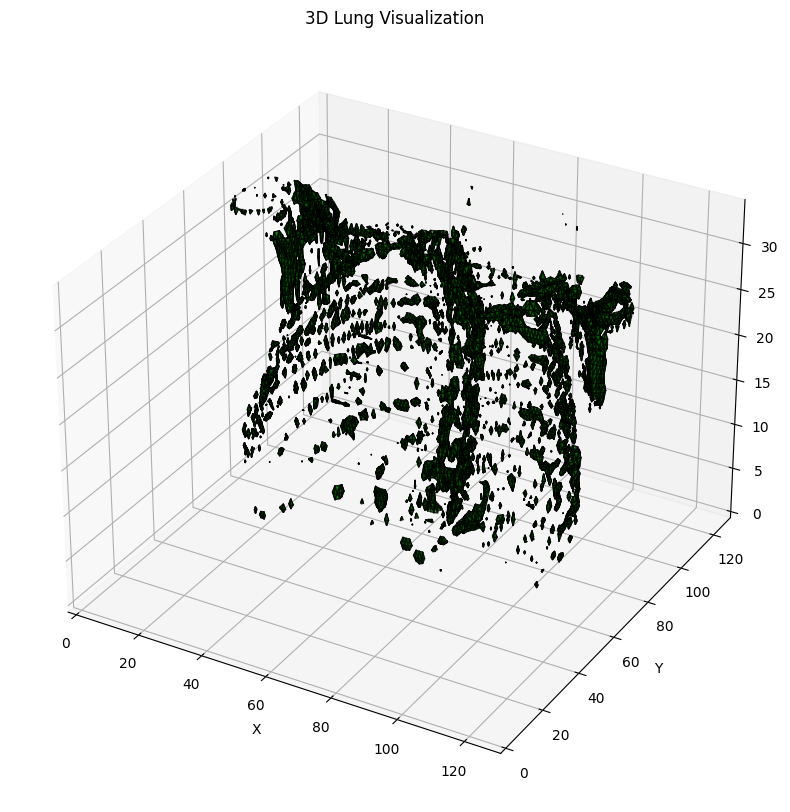


Analysis complete!


In [6]:
# Run the main function
if __name__ == "__main__":
    main()